# Prep stuff

## Installation

In [2]:
!pip install pydendroheatmap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Paths / Data

In [4]:
path0 = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/04_27_2022___13_59_29/calcium_raw_04_27_2022___13_59_29.csv"
path1 = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_05_2022___16_12_21/calcium_raw_05_05_2022___16_12_21.csv"
path2 = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_17_2022___16_15_20/calcium_raw_05_17_2022___16_15_20.csv"

data0 = np.genfromtxt(path0, delimiter = ",")[1:,1:]
data1 = np.genfromtxt(path1, delimiter = ",")[1:,1:]
data2 = np.genfromtxt(path2, delimiter = ",")[1:,1:]

params0 = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s0/04_27_2022___13_59_29/trial_parameters_04_27_2022___13_59_29.csv"
params1 = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_05_2022___16_12_21/trial_parameters_05_05_2022___16_12_21.csv"
params2 = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s2/05_17_2022___16_15_20/trial_parameters_05_17_2022___16_15_20.csv"

## Definitions

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import scipy, csv
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import AffinityPropagation, SpectralClustering, KMeans
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from io import StringIO
import pydendroheatmap as pdh

np.set_printoptions(precision=4, suppress=True)
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

class temp():
    def __init__(self, data, path, k=2, length=20, noise=None, res=None, tempRes=None, mode=True, paradigm="CI"):
        if paradigm == "CI":
            self.paradigm = 3
        else:
            self.paradigm = 2
        if tempRes != None: #test results
            self.results = self.tempRes
        else:
            self.results = self.getResults(path, length, res, mode,  self.paradigm)
        self.frames = self.clean(self.results[:,0:2], length)
        self.length = length
        self.data = data
        self.k = k
        self.path = path
        self.res = res
        
        self.axis_trials = np.shape(self.frames)[0]
        self.axis_freqs = self.length-self.k
        self.axis_cells = np.shape(data)[1]
        self.primary = np.zeros((self.axis_trials, self.axis_freqs, self.axis_cells))

        for trial in range(np.shape(self.frames)[0]):
            mat = self.data[self.frames[trial,0]:self.frames[trial,1], 0:]
            mat = np.real(np.fft.fft(mat, axis=0))
            mat = mat[self.k:self.length]
            self.primary[trial,:,:] = mat

            #VVV deprecated primary for reference VVV
            #self.primary[trial,:] = np.ndarray.flatten(np.transpose(mat))

        self.secondary = np.reshape(self.primary, (self.axis_trials, self.axis_freqs * self.axis_cells))
        self.gamma = self.scale(np.reshape(np.mean(self.primary, axis=0),(self.axis_cells, self.axis_freqs)))

        #self.secondary = self.scale(self.secondary)
        #self.primary = np.transpose(self.secondary)
        #print(np.shape(self.secondary))
        #self.dend(self.secondary)
        #self.kmeans(self.secondary)
        
        #print(self.results[:,2])
        #print(np.shape(self.secondary))
        #print(np.shape(self.frames))
        #print(np.shape(self.results))
        

        #self.acc, self.nacc = self.svcp(self.secondary, self.results[:,2])
        self.heatMap(self.gamma, self.res, self.length)

    def scale(self, data):
        #scaler = StandardScaler()
        scaler = MinMaxScaler()
        #print(scaler.transform(data))
        return scaler.fit_transform(data)

    def svcp(self, data, exp_out):
        X_train, X_test, y_train, y_test = train_test_split(data, exp_out, test_size = 0.25)
        classifier = SVC(kernel = "linear", random_state=0)
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)

        noise_x = np.random.rand(np.shape(data)[0],np.shape(data)[1])
        noise_y = np.random.randint(0, high=2, size=(np.shape(data)[0]))
        noise_pred = classifier.predict(noise_x)

        #cm = confusion_matrix(y_test, y_pred)
        #print(cm)
        #print(accuracy_score(y_test, y_pred))
        #clf = make_pipeline(StandardScaler(), SVC(gamma="auto"))
        #clf.fit(data, exp_out)
        return accuracy_score(y_test, y_pred), accuracy_score(noise_y, noise_pred)

    def clean(self, frames, length):
        for trial in range(np.shape(frames)[0]):
            if frames[trial,1]-frames[trial,0]<length:
                return self.clean(frames[np.arange(len(frames))!=trial] ,length)
        return frames

    def kmeans(self, data):
        kmeans = KMeans(n_clusters=2).fit(data)
        print(kmeans.labels_)
        #for i in range(10000):
        #    print(kmeans.labels_[i])

    def plot(self, data, length):
        plt.style.use('default')
        title = "Frame " + str(self.frames[0]) + " to " + str(self.frames[1])
        plt.figure(figsize=(4,2), dpi=150)
        plt.title(title)
        for cell in range(np.shape(self.data)[1]):
            plt.plot(np.arange(0,length,1), self.data[:,cell][:])
    
    def dend(self, data):
        Z = linkage(data, "ward")
        fig = plt.figure(figsize=(10,20))
        #fig = plt.figure(figsize=(7,5))
        dn = dendrogram(Z, orientation="right")
        plt.show()

    def spec(self, data):
        clustering = SpectralClustering(n_clusters=5, assign_labels="discretize").fit(data)
        print(clustering.labels_)

    '''
    def getResults(self, path, length):
        results = []
        with open(path) as csvfile:
            reader = csv.reader(csvfile, delimiter = ",")
            for row in reader:
                if row[4]=="clean" and int(row[7])-int(row[5])>length:
                    results.append(row)
                #results.append(row)
        results = np.array(results, dtype=object)
        turn = results[1:,3]#2 for LR 3 for correct/incorrect
        new_turn = np.zeros(np.shape(turn)[0])
        for i in range(np.shape(turn)[0]):
            if turn[i] == "correct":
                new_turn[i] = 1
            else:
                new_turn[i] = 0
        new_turn = new_turn[..., None]
        results = np.transpose(np.stack((results[1:,5], results[1:,7])))#5 for start, 8 for end, 7 for turn
        results = np.concatenate((results,new_turn),axis=1).astype(int)
        return results
    '''

    def getResults(self, path, length, res, mode, paradigm):
        '''
            Columns
            1 INIT v FTP
            2 L v R
            3 wrong vs correct
            4 messy vs clean
            5 trial start
            6 stim start
            7 turn frame
            8 trial end
            '''
        results = []
        with open(path) as csvfile:
            reader = csv.reader(csvfile, delimiter = ",")
            for row in reader:
                if row[4]=="clean" and int(row[7])-int(row[5])>length and (mode or row[1]=="INIT") and row[3]=="correct":
                    results.append(row)
                #results.append(row)
        results = np.array(results, dtype=object)
        input = results[1:, paradigm]#2 for LR 3 for correct/incorrect
        new_input = np.zeros(np.shape(input)[0])
        for i in range(np.shape(input)[0]):
            if res=="rand":
                if np.random.randint(2)==1:
                    new_input[i] = 1
                else:
                    new_input[i] = 0
            else:
                if input[i] == "correct":
                    new_input[i] = 1
                else:
                    new_input[i] = 0
        new_input = new_input[..., None]
        results = np.transpose(np.stack((results[1:,5], results[1:,7])))#5 for start, 8 for end, 7 for turn
        results = np.concatenate((results,new_input),axis=1).astype(int)
        return results
    
    def heatMap(self, data, res, length):
        heatmap = pdh.DendroHeatMap(heat_map_data=data)
        
        #heatmap.colormap = heatmap.yellowBlackBlue
        #heatmap.row_labels = np.arange(np.shape(data)[0])
        temp = np.around(np.arange(1/30, (np.shape(data)[1]+1)/30, 1/30),decimals=2)
        col_labels = []
        for freq in temp:
            col_labels.append(str(freq))
        heatmap.col_labels = col_labels
        heatmap.title = res, length
        heatmap.show()

'''
def compute_DM(data, params, trials, sizes):
    output = np.zeros((1225+1, 4, trials))
    for trial in range(trials):
        print("starting trial", trial)
        count=0
        for upper_band in range(50):
            for lower_band in range(upper_band):
                b = temp(data, params, k=lower_band, length=upper_band)
                count = count+1
                output[count,:,trial] = output[count,:,trial] + np.array([b.acc,b.nacc,j,i])
                if(b.acc>0.9):print(b.acc,"," ,j , ",", i)
'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'\ndef compute_DM(data, params, trials, sizes):\n    output = np.zeros((1225+1, 4, trials))\n    for trial in range(trials):\n        print("starting trial", trial)\n        count=0\n        for upper_band in range(50):\n            for lower_band in range(upper_band):\n                b = temp(data, params, k=lower_band, length=upper_band)\n                count = count+1\n                output[count,:,trial] = output[count,:,trial] + np.array([b.acc,b.nacc,j,i])\n                if(b.acc>0.9):print(b.acc,"," ,j , ",", i)\n'

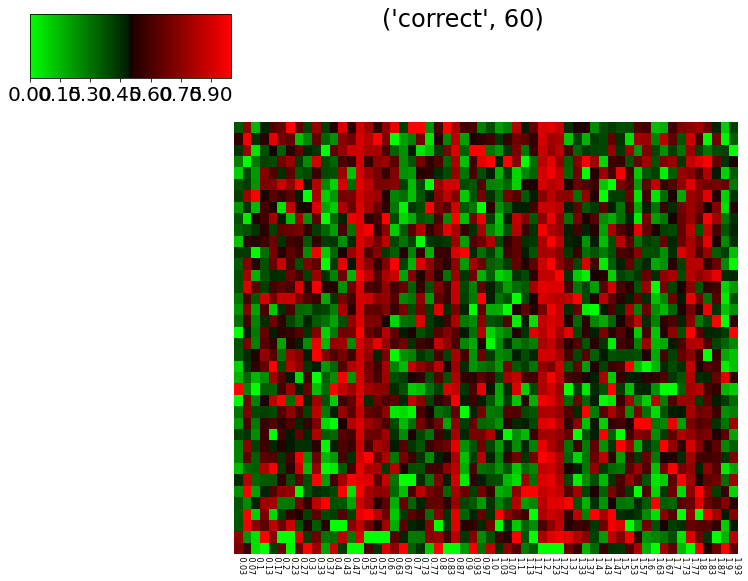

In [58]:
a = temp(data1, params1, length=60, res="correct")
#print(a.acc, a.nacc)

# Execution

## Main

In [ ]:
for i in range(5):
    for j in range(i):
        b = temp(data2, params2, k=j, length=i, res="rand")
        if(b.acc>0.8): print(b.acc, ",", b.nacc,",", j, ",", i,)
        #print(b.acc, ",", j, ",", i)

In [ ]:
trials = 10
max_freq = 50
min_acc = 0.9

axis_0 = int(0.5 * max_freq * (max_freq-1))+1 #axis_0 = 1225+1 for max_freq = 50 ref

s0 = np.zeros((axis_0, 4, trials))
for k in range(trials):
    print("starting trial", k)
    count = 0
    for i in range(max_freq):
        #print(count)
        for j in range(i):
            b = temp(data0, params0, k=j, length=i)
            count = count + 1
            s0[count,:,k] = s0[count,:,k] + np.array([b.acc, b.nacc, j, i])
            if(b.acc>min_acc): print(b.acc, ",", j, ",", i)

s1 = np.zeros((axis_0, 4, trials))
for k in range(trials):
    print("starting trial", k)
    count = 0
    for i in range(max_freq):
        #print(count)
        for j in range(i):
            b = temp(data1, params1, k=j, length=i)
            count = count + 1
            s1[count,:,k] = s1[count,:,k] + np.array([b.acc, b.nacc, j, i])
            if(b.acc>min_acc): print(b.acc, ",", j, ",", i)

s2 = np.zeros((axis_0, 4, trials))
for k in range(trials):
    print("starting trial", k)
    count = 0
    for i in range(max_freq):
        #print(count)
        for j in range(i):
            b = temp(data2, params2, k=j, length=i, mode=False)
            count = count + 1
            s2[count,:,k] = s2[count,:,k] + np.array([b.acc, b.nacc, j, i])
            if(b.acc>min_acc): print(b.acc, ",", j, ",", i)
        
np.save(s0)
np.save(s1)
np.save(s2)

## Analysis

In [ ]:
def analyze(total_dataset, parameters):
    '''
    axis_0 = Predictions within a given randomization
    axis_1 = Recorded Information from a given prediction
    axis_2 = Randomization iteration
    '''
    col = 0
    output = np.zeros((np.shape(total_dataset)[0], np.shape(parameters)[0]))
    for parameter in parameters:
        param = getattr(np, parameter)
        for row in range(np.shape(total_dataset)[0]):
            output[row, col] = param(total_dataset, axis=2)
        col = col + 1
    return np.transpose(output)

In [ ]:
parameters = ["std", "mean", "amin", "amax"]
#analyze(data, parameters)

# Old

In [ ]:
trials = 10
final_mat = np.zeros((1225+1, 4, trials))
for k in range(trials):
    print("starting", k)
    count = 0
    for i in range(50):
        #print(count)
        for j in range(i):
            b = temp(data, params2, k=j, length=i)
            count = count + 1
            final_mat[count,:,k] = final_mat[count,:,k] + np.array([b.acc, b.nacc, j, i])
            #if(b.acc>0.9): print(b.acc, ",", j, ",", i)

starting 0
starting 1
starting 2
starting 3
starting 4
starting 5
starting 6
starting 7
starting 8
starting 9


In [ ]:
yeee = np.std(final_mat, axis=2)
print(yeee)
print(np.amax(yeee, axis=0))
yeee2 = np.mean(final_mat, axis=2)
print(yeee2)
print(np.amax(yeee2, axis=0))

[[0.     0.     0.     0.    ]
 [0.084  0.0452 0.     0.    ]
 [0.0911 0.0467 0.     0.    ]
 ...
 [0.0742 0.0584 0.     0.    ]
 [0.067  0.0591 0.     0.    ]
 [0.0629 0.0684 0.     0.    ]]
[0.173  0.1045 0.     0.    ]
[[ 0.      0.      0.      0.    ]
 [ 0.6824  0.5552  0.      1.    ]
 [ 0.7059  0.4672  0.      2.    ]
 ...
 [ 0.7067  0.4817 46.     49.    ]
 [ 0.6867  0.4967 47.     49.    ]
 [ 0.7267  0.4767 48.     49.    ]]
[ 0.8812  0.5651 48.     49.    ]


In [ ]:
trials = 5
final_mat2 = np.zeros((1225+1, 4, trials))
for k in range(trials):
    print("starting", k)
    count = 0
    for i in range(50):
        #print(count)
        for j in range(i):
            print(j,i)
            b = temp(data0, params0, k=j, length=i, res="rand")
            count = count + 1
            final_mat2[count,:,k] = final_mat2[count,:,k] + np.array([b.acc, b.nacc, j, i])
            #if(b.acc>0.9): print(b.acc, ",", j, ",", i)

starting 0
0 1
0 2
1 2
0 3
1 3
2 3
0 4
1 4
2 4
3 4
0 5
1 5
2 5
3 5
4 5
0 6
1 6
2 6
3 6
4 6
5 6
0 7
1 7
2 7
3 7
4 7
5 7
6 7
0 8
1 8
2 8
3 8
4 8
5 8
6 8
7 8
0 9
1 9
2 9
3 9
4 9
5 9
6 9
7 9
8 9
0 10
1 10
2 10
3 10
4 10
5 10
6 10
7 10
8 10
9 10


KeyboardInterrupt: ignored

In [ ]:
yeee = np.std(final_mat2, axis=2)
#print(yeee)
print(np.amax(yeee, axis=0))
yeee2 = np.mean(final_mat2, axis=2)
#print(yeee2)
print(np.mean(yeee2, axis=0))

[0.3651 0.1898 0.     0.    ]
[ 0.4958  0.5002 15.9869 32.9731]


In [ ]:
for i in range(99):
    for j in range(i):
        b = temp(data, params, k=j, length=i)
        if(b.acc>0.9): print(b.acc, ",", j, ",", i)

KeyboardInterrupt: ignored

In [ ]:
#path = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s1/05_06_2022___15_20_00/calcium_raw_05_06_2022___15_20_00.csv"
path2 = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_05_2022___16_12_21/calcium_raw_05_05_2022___16_12_21.csv"
data2 = np.genfromtxt(path2, delimiter = ",")[1:,1:]

params2 = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_05_2022___16_12_21/trial_parameters_05_05_2022___16_12_21.csv"



In [ ]:
b = temp(data2, params2, k=1, length=5)
print(b.acc)

0.6341463414634146


In [ ]:
for i in range(2,10):
    for j in range(i):
        b = temp(data2, params2, k=j, length=i)
        #if(b.acc>0.8): print(b.acc, ",", j, ",", i)
        print(b.acc, ",", j, ",", i)

0.36585365853658536 , 0 , 2


In [ ]:
for i in range(5,60):
    for j in range(i-1):
        b = temp(data2, params2, k=j, length=i)
        if(b.acc>0.7):print(b.acc, ",", j, ",", i)
        #print(b.acc, ",", 2, ",", i)
        #print("yee")
print("done")

0.725 , 2 , 29
0.725 , 4 , 29
0.75 , 19 , 30
0.7105263157894737 , 17 , 35
0.7105263157894737 , 22 , 35
0.7105263157894737 , 34 , 36
0.7142857142857143 , 1 , 56
0.7142857142857143 , 54 , 56
0.7142857142857143 , 5 , 57
0.7142857142857143 , 46 , 57
0.7857142857142857 , 1 , 58
done


In [ ]:
#path = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m11n/s1/05_06_2022___15_20_00/calcium_raw_05_06_2022___15_20_00.csv"
path3 = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_12_2022___13_28_46/calcium_raw_05_12_2022___13_28_46.csv"
data3 = np.genfromtxt(path3, delimiter = ",")[1:,1:]

params3 = "/content/drive/MyDrive/CalciumImaging_Lur のコピー/mice_datasets/m12lr/s1/05_12_2022___13_28_46/trial_parameters_05_12_2022___13_28_46.csv"



In [ ]:
for i in range(5,60):
    for j in range(i-1):
        b = temp(data3, params3, k=j, length=i)
        if(b.acc>0.7):print(b.acc, ",", j, ",", i)
        #print(b.acc, ",", 2, ",", i)
        #print("yee")
print("done")

0.8787878787878788 , 1 , 5
0.8787878787878788 , 2 , 5
0.8181818181818182 , 3 , 5
0.8181818181818182 , 0 , 6
0.8484848484848485 , 1 , 6
0.7878787878787878 , 2 , 6
0.8181818181818182 , 3 , 6
0.8484848484848485 , 4 , 6
0.7575757575757576 , 0 , 7
0.7878787878787878 , 1 , 7
0.7878787878787878 , 2 , 7
0.8484848484848485 , 3 , 7
0.9090909090909091 , 4 , 7
0.7575757575757576 , 5 , 7
0.8181818181818182 , 0 , 8
0.7575757575757576 , 1 , 8
0.7878787878787878 , 2 , 8
0.8787878787878788 , 3 , 8
0.7878787878787878 , 4 , 8
0.7575757575757576 , 5 , 8
0.7575757575757576 , 6 , 8
0.7575757575757576 , 0 , 9
0.8484848484848485 , 1 , 9
0.8181818181818182 , 2 , 9
0.7272727272727273 , 3 , 9
0.9090909090909091 , 4 , 9
0.9696969696969697 , 5 , 9
0.8484848484848485 , 6 , 9
0.7272727272727273 , 0 , 10
0.7575757575757576 , 2 , 10
0.8787878787878788 , 3 , 10
0.8484848484848485 , 4 , 10
0.8181818181818182 , 5 , 10
0.8181818181818182 , 6 , 10
0.8181818181818182 , 7 , 10
0.8484848484848485 , 8 , 10
0.7575757575757576 ,